<center><h1>Sales Prediction</h1></center>
    <img src = "https://ierp.ai/wp-content/uploads/2021/01/Sales-Forecast-Blog.png">
    

Table of contents:

1. [Import relevant libraries](#Libraries)
2. [Load files](#Load)
3. [Data Exploration](#Exploration)
4. [Data Cleaning](#Cleaning)
5. [EDA(Exploratory Data Analysis)](#EDA)
6. [Preprocessing Data](#Cleaning)
7. [Correlations & Distributions ](#Correlations)
8. [Splitting the Data](#Splitting)
9. [Model training](#Model)
10. [Test set predictions](#Predictions)

<a name = "Libraries"></a>
## 1. Import relevant libraries

In [1]:
# Install xgboost
# !pip install xgboost
# !pip install imbalanced-learn
# !pip install ipywidgets
# !jupyter nbextension enable --py widgetsnbextension

In [5]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: wheel<1.0,>=0.23.0 in c:\users\benma\anaconda3\lib\site-packages (from astunparse>=1.6.0->tensorflow-intel==2.12.0->tensorflow) (0.37.1)



In [7]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices()
print("Available physical devices:", physical_devices)

Available physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [6]:
import tensorflow as tf
print(tf.test.gpu_device_name())

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns 
import time

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import tree
from scipy import stats
from ipywidgets import IntProgress, HTML, VBox
import ipywidgets as widgets
from IPython.display import display
from tqdm import tqdm
from tqdm.auto import tqdm

from sklearn.preprocessing import StandardScaler,OrdinalEncoder,LabelEncoder,MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score ,KFold
from xgboost import plot_importance

pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

sns.set_style("darkgrid")

<a name = "Load"></a>
## 2. Load files

In [3]:
#Loading dataset
df = pd.read_excel('newdata.xlsx')
df.describe().T.style.background_gradient(cmap='Greens')

,count,mean,std,min,25%,50%,75%,max
id_segment,51318.000000,1.783838,0.878129,1.000000,1.000000,1.000000,3.000000,3.000000
id_state,5824.000000,87.396806,45.506065,1.000000,49.000000,97.000000,121.000000,175.000000
Unit Price,51318.000000,237.682314,126.278644,19.000000,128.000000,238.000000,347.000000,457.000000
quantity,51318.000000,3.476071,2.278623,1.000000,2.000000,3.000000,5.000000,14.000000
discount,51318.000000,0.142907,0.212283,0.000000,0.000000,0.000000,0.200000,0.850000
shipping_cost,51318.000000,26.365946,57.284882,0.000000,2.610000,7.790000,24.440000,933.570000
sales,51318.000000,826.174305,752.664627,19.000000,296.000000,604.000000,1125.000000,6398.000000
expenses,51318.000000,641.180059,609.041486,4.489200,217.439100,448.367550,855.949500,5597.049300
revenue,51318.000000,736.988574,700.047685,5.160000,249.930000,515.365000,983.850000,6433.390000
year,51318.000000,2012.778713,1.149308,2001.000000,2012.000000,2013.000000,2014.000000,2088.000000


In [4]:
data = pd.DataFrame(df)

<a name = "Exploration"></a>
## 3. Data Exploration

In [5]:
data.set_index("order_id",inplace=True)
data.head()

,order_date,ship_date,ship_mode,customer_name,id_segment,segment,id_state,state,country,market,region,product_id,category,sub_category,product_name,product_name.1,product_name.2,product_name.3,product_name.4,product_name.5,Unit Price,quantity,discount,shipping_cost,order_priority,sales,expenses,revenue,year
order_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ES-2011-1630549,2011-04-16,2011-04-21,Standard Class,Dianna Wilson,2,Home Office,1.0,Abia,Nigeria,Africa,Africa,OFF-BOS-10001348,OFFICE SUPPLIES,ART,Boston Pencil Sharpener,Water Color,NaN,NaN,NaN,NaN,117,14,0.7,10.61,Medium,1638,436.7487,502.01,2011
MX-2013-132906,2012-05-25,2012-05-30,Standard Class,Denny Joy,3,Corporate,1.0,Abia,Nigeria,Africa,Africa,OFF-FIS-10001797,OFFICE SUPPLIES,SUPPLIES,Fiskars Trimmer,Steel,NaN,NaN,NaN,NaN,274,1,0.7,0.20,Medium,274,71.6880,82.40,2012
MX-2013-113579,2012-07-13,2012-07-17,Standard Class,Arthur Wiediger,2,Home Office,1.0,Abia,Nigeria,Africa,Africa,OFF-SME-10001718,OFFICE SUPPLIES,STORAGE,Smead Box,Industrial,NaN,NaN,NaN,NaN,439,1,0.7,0.26,Medium,439,114.8052,131.96,2012
CA-2013-116337,2012-09-04,2012-09-08,Standard Class,Dean Braden,1,Consumer,1.0,Abia,Nigeria,Africa,Africa,OFF-SME-10001718,OFFICE SUPPLIES,STORAGE,Smead Box,Industrial,NaN,NaN,NaN,NaN,28,2,0.7,0.58,Medium,56,15.1206,17.38,2012
ES-2013-4232414,2012-09-04,2012-09-08,Standard Class,Dean Braden,1,Consumer,1.0,Abia,Nigeria,Africa,Africa,OFF-BIN-10004512,OFFICE SUPPLIES,ART,Binney & Smith Pens,Easy-Erase,NaN,NaN,NaN,NaN,344,2,0.7,0.41,Medium,688,179.9247,206.81,2012


In [6]:
data.describe()

,id_segment,id_state,Unit Price,quantity,discount,shipping_cost,sales,expenses,revenue,year
count,51318.000000,5824.000000,51318.000000,51318.000000,51318.000000,51318.000000,51318.000000,51318.000000,51318.000000,51318.000000
mean,1.783838,87.396806,237.682314,3.476071,0.142907,26.365946,826.174305,641.180059,736.988574,2012.778713
std,0.878129,45.506065,126.278644,2.278623,0.212283,57.284882,752.664627,609.041486,700.047685,1.149308
min,1.000000,1.000000,19.000000,1.000000,0.000000,0.000000,19.000000,4.489200,5.160000,2001.000000
25%,1.000000,49.000000,128.000000,2.000000,0.000000,2.610000,296.000000,217.439100,249.930000,2012.000000
50%,1.000000,97.000000,238.000000,3.000000,0.000000,7.790000,604.000000,448.367550,515.365000,2013.000000
75%,3.000000,121.000000,347.000000,5.000000,0.200000,24.440000,1125.000000,855.949500,983.850000,2014.000000
max,3.000000,175.000000,457.000000,14.000000,0.850000,933.570000,6398.000000,5597.049300,6433.390000,2088.000000


<a name = "Cleaning"></a>
## 4. Data Cleaning

### Handeling Duplications 

In [7]:
data.duplicated().value_counts()

False    51296
True        22
dtype: int64

In [8]:
# Removing duplications
duplicated_mask = data.duplicated()
data = data[~duplicated_mask]

In [9]:
data.duplicated().any()

False

In [10]:
data

,order_date,ship_date,ship_mode,customer_name,id_segment,segment,id_state,state,country,market,region,product_id,category,sub_category,product_name,product_name.1,product_name.2,product_name.3,product_name.4,product_name.5,Unit Price,quantity,discount,shipping_cost,order_priority,sales,expenses,revenue,year
order_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ES-2011-1630549,2011-04-16,2011-04-21,Standard Class,Dianna Wilson,2,Home Office,1.0,Abia,Nigeria,Africa,Africa,OFF-BOS-10001348,OFFICE SUPPLIES,ART,Boston Pencil Sharpener,Water Color,NaN,NaN,NaN,NaN,117,14,0.7,10.61,Medium,1638,436.7487,502.01,2011
MX-2013-132906,2012-05-25,2012-05-30,Standard Class,Denny Joy,3,Corporate,1.0,Abia,Nigeria,Africa,Africa,OFF-FIS-10001797,OFFICE SUPPLIES,SUPPLIES,Fiskars Trimmer,Steel,NaN,NaN,NaN,NaN,274,1,0.7,0.20,Medium,274,71.6880,82.40,2012
MX-2013-113579,2012-07-13,2012-07-17,Standard Class,Arthur Wiediger,2,Home Office,1.0,Abia,Nigeria,Africa,Africa,OFF-SME-10001718,OFFICE SUPPLIES,STORAGE,Smead Box,Industrial,NaN,NaN,NaN,NaN,439,1,0.7,0.26,Medium,439,114.8052,131.96,2012
CA-2013-116337,2012-09-04,2012-09-08,Standard Class,Dean Braden,1,Consumer,1.0,Abia,Nigeria,Africa,Africa,OFF-SME-10001718,OFFICE SUPPLIES,STORAGE,Smead Box,Industrial,NaN,NaN,NaN,NaN,28,2,0.7,0.58,Medium,56,15.1206,17.38,2012
ES-2013-4232414,2012-09-04,2012-09-08,Standard Class,Dean Braden,1,Consumer,1.0,Abia,Nigeria,Africa,Africa,OFF-BIN-10004512,OFFICE SUPPLIES,ART,Binney & Smith Pens,Easy-Erase,NaN,NaN,NaN,NaN,344,2,0.7,0.41,Medium,688,179.9247,206.81,2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SU-2014-3390,2014-08-12,2014-08-19,Standard Class,Cathy Hwang,2,Home Office,NaN,Zürich,Italy,EU,South,TEC-PH-10003713,TECHNOLOGY,PHONES,Cisco Audio Dock,Cordless,NaN,NaN,NaN,NaN,293,4,0.4,32.70,Low,1172,640.2330,735.90,2014
EZ-2014-8670,2014-10-13,2014-10-17,Standard Class,Tony Sayre,1,Consumer,NaN,Zürich,Germany,EU,Central,OFF-SU-10000906,OFFICE SUPPLIES,SUPPLIES,Fiskars Shears,High Speed,NaN,NaN,NaN,NaN,315,6,0.0,21.16,Critical,1890,1662.7092,1911.16,2014
MO-2014-6030,2014-10-13,2014-10-17,Standard Class,Tony Sayre,1,Consumer,NaN,Zürich,Australia,APAC,Oceania,OFF-PA-10003744,OFFICE SUPPLIES,PAPER,Green Bar Parchment Paper,Multicolor,NaN,NaN,NaN,NaN,419,4,0.1,9.61,High,1676,1320.6687,1518.01,2014


### Handeling missing data 

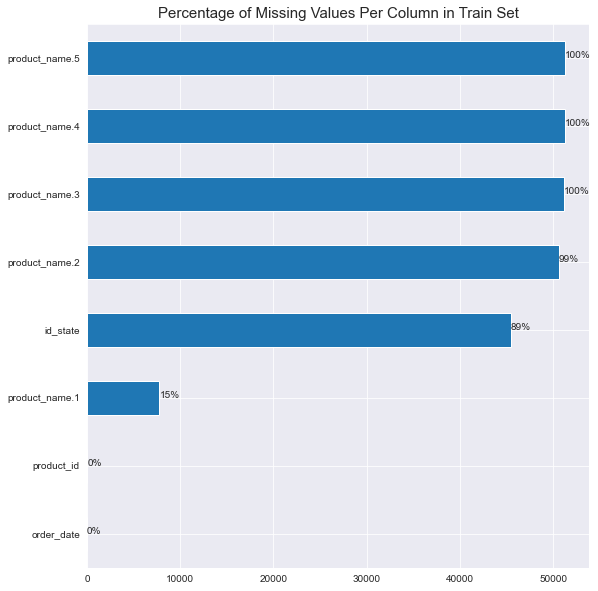

In [11]:
# Plot missing values in train set
ax = data.isna().sum().sort_values(ascending = False)[:8][::-1].plot(kind = 'barh', figsize = (9, 10))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/data.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

In [12]:
data = data.drop(['product_name.1','product_name.2','product_name.3','product_name.4','product_name.5','id_state'],axis=1)

In [13]:
#Information about the data columns
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51296 entries, ES-2011-1630549 to IN-2011-71242
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   order_date      51296 non-null  datetime64[ns]
 1   ship_date       51296 non-null  datetime64[ns]
 2   ship_mode       51296 non-null  object        
 3   customer_name   51296 non-null  object        
 4   id_segment      51296 non-null  int64         
 5   segment         51296 non-null  object        
 6   state           51296 non-null  object        
 7   country         51296 non-null  object        
 8   market          51296 non-null  object        
 9   region          51296 non-null  object        
 10  product_id      51275 non-null  object        
 11  category        51296 non-null  object        
 12  sub_category    51296 non-null  object        
 13  product_name    51296 non-null  object        
 14  Unit Price      51296 non-null  int64

In [14]:
data.shape

(51296, 23)

In [15]:
data.isnull().sum()

order_date         0
ship_date          0
ship_mode          0
customer_name      0
id_segment         0
segment            0
state              0
country            0
market             0
region             0
product_id        21
category           0
sub_category       0
product_name       0
Unit Price         0
quantity           0
discount           0
shipping_cost      0
order_priority     0
sales              0
expenses           0
revenue            0
year               0
dtype: int64

In [16]:
data = data.dropna()

In [17]:
data.isna().sum()

order_date        0
ship_date         0
ship_mode         0
customer_name     0
id_segment        0
segment           0
state             0
country           0
market            0
region            0
product_id        0
category          0
sub_category      0
product_name      0
Unit Price        0
quantity          0
discount          0
shipping_cost     0
order_priority    0
sales             0
expenses          0
revenue           0
year              0
dtype: int64

In [18]:
data.columns.values

array(['order_date', 'ship_date', 'ship_mode', 'customer_name',
       'id_segment', 'segment', 'state', 'country', 'market', 'region',
       'product_id', 'category', 'sub_category', 'product_name',
       'Unit Price', 'quantity', 'discount', 'shipping_cost',
       'order_priority', 'sales', 'expenses', 'revenue ', 'year'],
      dtype=object)

<a name = "EDA"></a>
## 4. EDA(Exploratory Data Analysis)


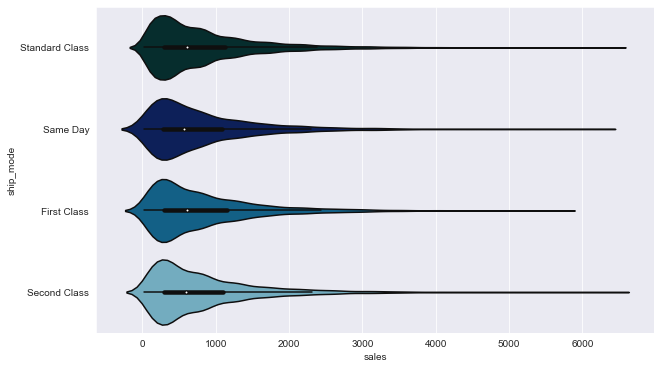

In [19]:
fig = plt.figure(figsize = (10,6))
sns.violinplot(x = 'sales', y = 'ship_mode', data = data,palette='ocean')
plt.show()

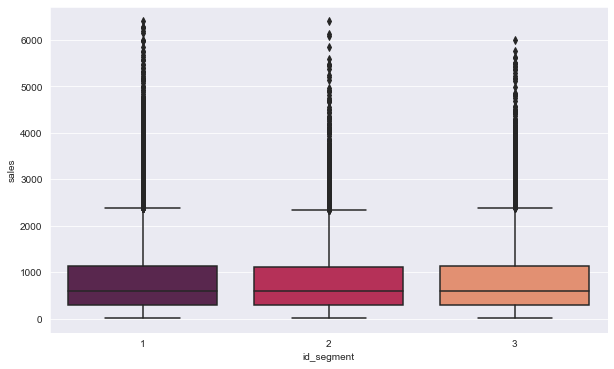

In [20]:
fig = plt.figure(figsize = (10,6))
sns.boxplot(x = 'id_segment', y = 'sales', data = data,palette='rocket')
plt.show()

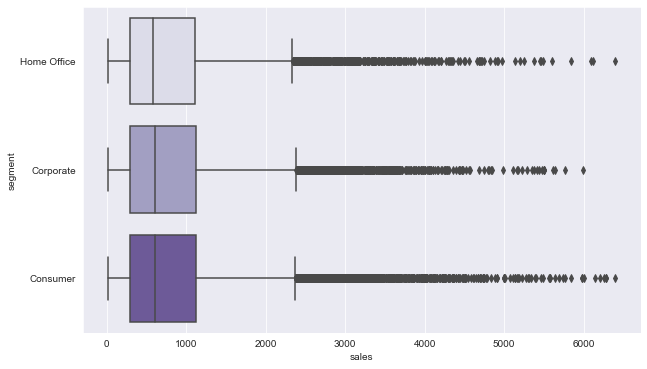

In [21]:
fig = plt.figure(figsize = (10,6))
sns.boxplot(x = 'sales', y = 'segment', data = data,palette='Purples')
plt.show()

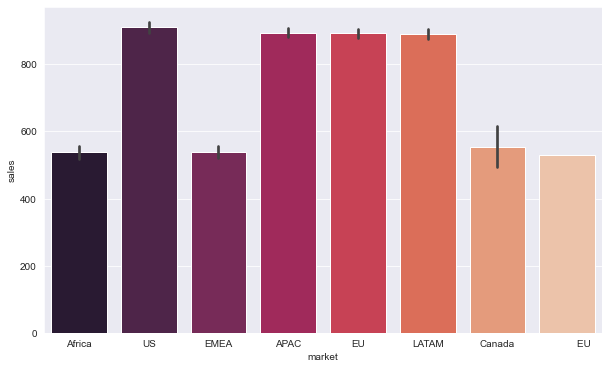

In [22]:
fig = plt.figure(figsize = (10,6))
sns.barplot(x = 'market', y = 'sales', data = data,palette='rocket')
plt.show()

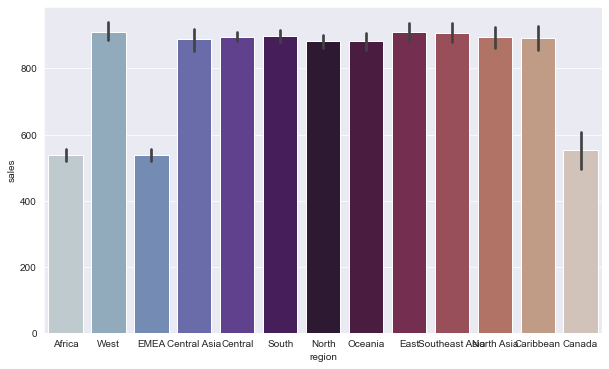

In [23]:
fig = plt.figure(figsize = (10,6))
sns.barplot(x = 'region', y = 'sales', data = data,palette='twilight')
plt.show()

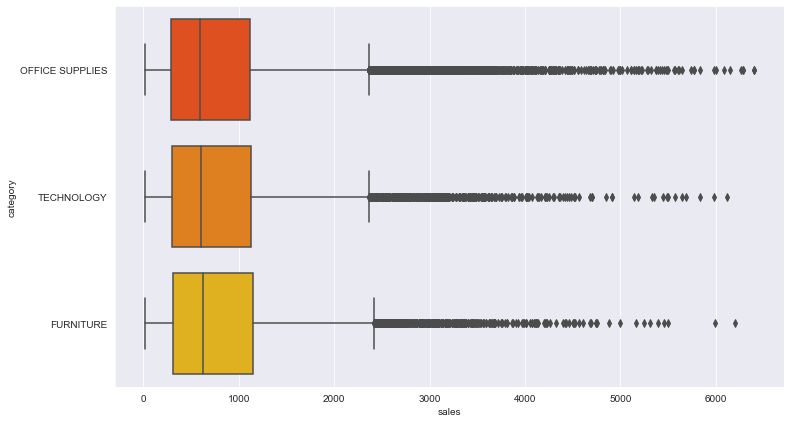

In [24]:
plt.figure(figsize=(12,7))
sns.boxplot(data['sales'],data['category'],palette='autumn')
plt.show()

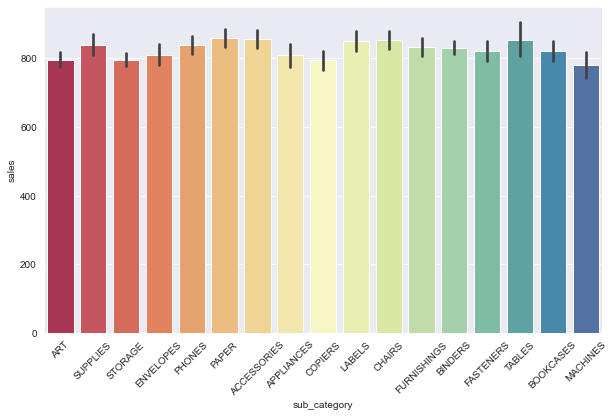

In [25]:
fig = plt.figure(figsize = (10,6))
sns.barplot(x = 'sub_category', y = 'sales', data = data,palette='Spectral')
plt.xticks(rotation=45)
plt.show()

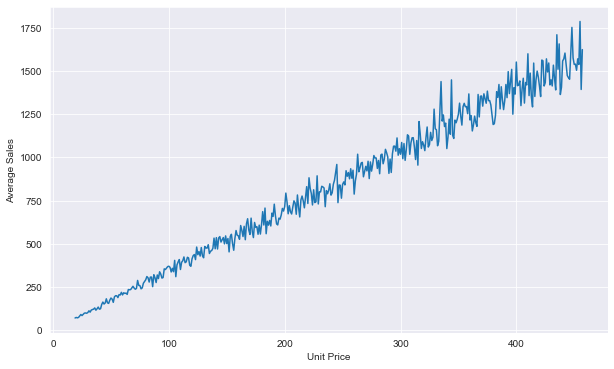

In [26]:
fig = plt.figure(figsize = (10,6))
up = data.groupby('Unit Price')['sales'].mean().reset_index()
plt.plot(up['Unit Price'],up['sales'])
plt.xlabel('Unit Price')
plt.ylabel('Average Sales')
plt.show()

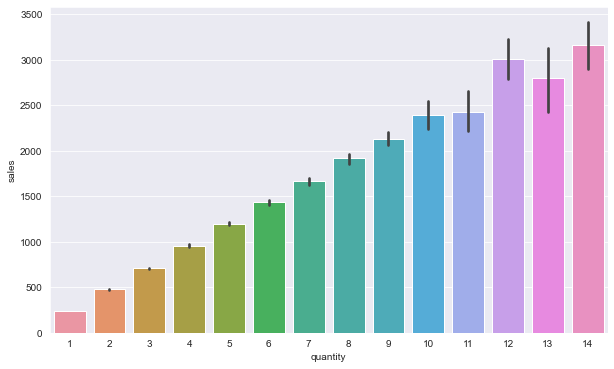

In [27]:
fig = plt.figure(figsize = (10,6))
sns.barplot(x = 'quantity', y = 'sales', data = data)
plt.show()

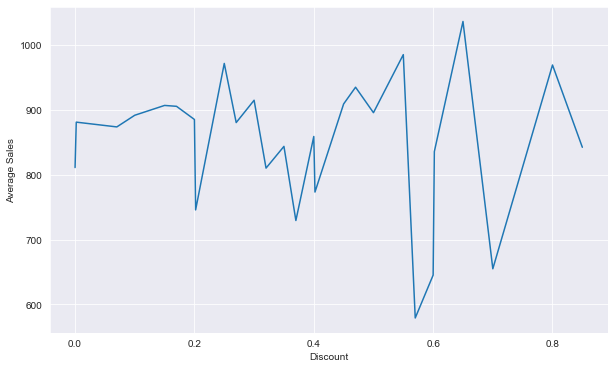

In [28]:
fig = plt.figure(figsize = (10,6))
dis = data.groupby('discount')['sales'].mean().reset_index()
plt.plot(dis['discount'],dis['sales'])
plt.xlabel('Discount')
plt.ylabel('Average Sales')
plt.show()

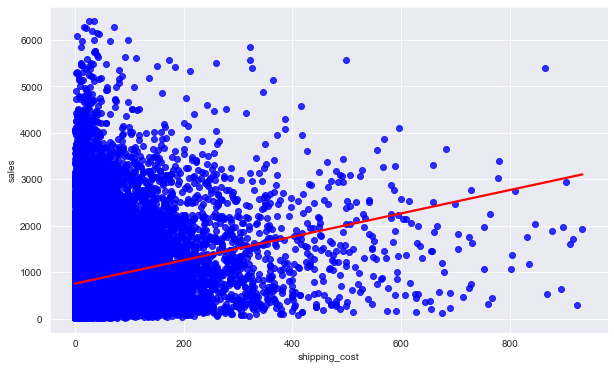

In [29]:
fig = plt.figure(figsize = (10,6))
sns.regplot(x = 'shipping_cost', y = 'sales', data = data, line_kws={"color": "red"}, 
            scatter_kws={"color": "blue"},ci=False)
plt.show()

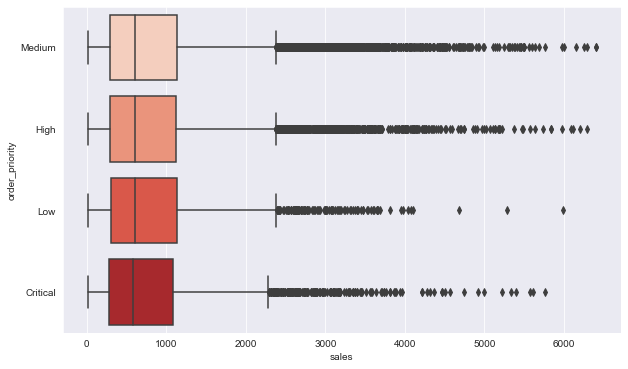

In [30]:
fig = plt.figure(figsize = (10,6))
sns.boxplot(x = 'sales', y = 'order_priority', data = data,palette='Reds')
plt.show()

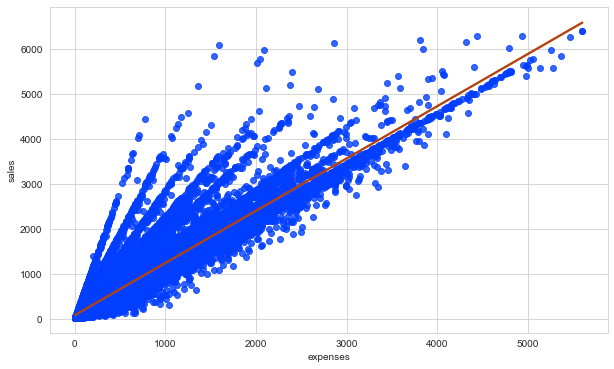

In [31]:
fig = plt.figure(figsize = (10,6))
sns.set_style("whitegrid")
sns.regplot(x = 'expenses', y = 'sales', data = data,line_kws={"color": sns.color_palette("dark")[1]}, 
            scatter_kws={"color": sns.color_palette("bright")[0]})
plt.show()

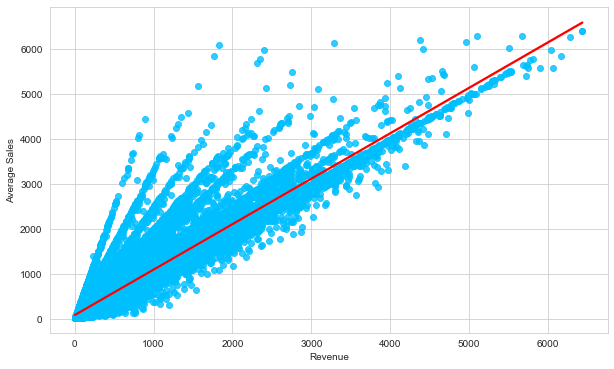

In [32]:
fig = plt.figure(figsize = (10,6))
custom_palette = sns.color_palette(["#FFC0CB", "#00BFFF"])
sns.regplot(x = 'revenue ', y = 'sales', data = data, line_kws={"color": "red"}, 
            scatter_kws={"color": custom_palette[1]})
plt.xlabel('Revenue')
plt.ylabel('Average Sales')
plt.show()

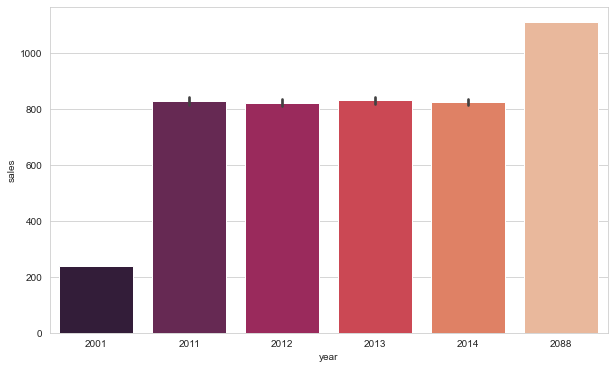

In [33]:
fig = plt.figure(figsize = (10,6))
sns.barplot(x = 'year', y = 'sales', data = data,palette='rocket')
plt.show()

<a name = "Cleaning"></a>
## 5. Preprocessing Data

### Handeling Categorical Attributes

In [34]:
data.columns

Index(['order_date', 'ship_date', 'ship_mode', 'customer_name', 'id_segment',
       'segment', 'state', 'country', 'market', 'region', 'product_id',
       'category', 'sub_category', 'product_name', 'Unit Price', 'quantity',
       'discount', 'shipping_cost', 'order_priority', 'sales', 'expenses',
       'revenue ', 'year'],
      dtype='object')

In [35]:
print(data['ship_mode'].unique())

['Standard Class' 'Same Day' 'First Class' 'Second Class']


In [36]:
dummies = pd.get_dummies(data["ship_mode"], prefix="ship-mode",drop_first=True)
data = pd.concat([data, dummies], axis=1)
data = data.drop("ship_mode", axis=1)

In [37]:
data['segment'].unique()

array(['Home Office', 'Corporate', 'Consumer'], dtype=object)

In [38]:
dummies = pd.get_dummies(data["segment"], prefix="seg",drop_first=True)
data = pd.concat([data,dummies],axis=1)
data = data.drop("segment",axis=1)

In [39]:
data['market'].unique()

array(['Africa', 'US', 'EMEA', 'APAC', 'EU', 'LATAM', 'Canada',
       '            EU'], dtype=object)

In [40]:
dummies = pd.get_dummies(data["market"], prefix="mar",drop_first=True)
data = pd.concat([data,dummies],axis=1)
data = data.drop("market",axis=1)

In [41]:
data['region'].unique()

array(['Africa', 'West', 'EMEA', 'Central Asia', 'Central', 'South',
       'North', 'Oceania', 'East', 'Southeast Asia', 'North Asia',
       'Caribbean', 'Canada'], dtype=object)

In [42]:
dummies = pd.get_dummies(data["region"], prefix="reg",drop_first=True)
data = pd.concat([data,dummies],axis=1)
data = data.drop("region",axis=1)

In [43]:
data['category'].unique()

array(['OFFICE SUPPLIES', 'TECHNOLOGY', 'FURNITURE'], dtype=object)

In [44]:
dummies = pd.get_dummies(data["category"], prefix="cat",drop_first=True)
data = pd.concat([data,dummies],axis=1)
data = data.drop("category",axis=1)

In [45]:
data['sub_category'].unique()

array(['ART', 'SUPPLIES', 'STORAGE', 'ENVELOPES', 'PHONES', 'PAPER',
       'ACCESSORIES', 'APPLIANCES', 'COPIERS', 'LABELS', 'CHAIRS',
       'FURNISHINGS', 'BINDERS', 'FASTENERS', 'TABLES', 'BOOKCASES',
       'MACHINES'], dtype=object)

In [46]:
dummies = pd.get_dummies(data["sub_category"], prefix="sub_cat",drop_first=True)
data = pd.concat([data,dummies],axis=1)
data = data.drop("sub_category",axis=1)

In [47]:
data['order_priority'].unique()

array(['Medium', 'High', 'Low', 'Critical'], dtype=object)

In [48]:
dummies = pd.get_dummies(data["order_priority"], prefix="ord",drop_first=True)
data = pd.concat([data,dummies],axis=1)
data = data.drop("order_priority",axis=1)

In [49]:
le = LabelEncoder()
data["country"] = le.fit_transform(data["country"])

In [50]:
le = LabelEncoder()
data["state"] = le.fit_transform(data["state"])

In [51]:
data.head()

,order_date,ship_date,customer_name,id_segment,state,country,product_id,product_name,Unit Price,quantity,discount,shipping_cost,sales,expenses,revenue,year,ship-mode_Same Day,ship-mode_Second Class,ship-mode_Standard Class,seg_Corporate,seg_Home Office,mar_APAC,mar_Africa,mar_Canada,mar_EMEA,mar_EU,mar_LATAM,mar_US,reg_Canada,reg_Caribbean,reg_Central,reg_Central Asia,reg_EMEA,reg_East,reg_North,reg_North Asia,reg_Oceania,reg_South,reg_Southeast Asia,reg_West,cat_OFFICE SUPPLIES,cat_TECHNOLOGY,sub_cat_APPLIANCES,sub_cat_ART,sub_cat_BINDERS,sub_cat_BOOKCASES,sub_cat_CHAIRS,sub_cat_COPIERS,sub_cat_ENVELOPES,sub_cat_FASTENERS,sub_cat_FURNISHINGS,sub_cat_LABELS,sub_cat_MACHINES,sub_cat_PAPER,sub_cat_PHONES,sub_cat_STORAGE,sub_cat_SUPPLIES,sub_cat_TABLES,ord_High,ord_Low,ord_Medium
order_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ES-2011-1630549,2011-04-16,2011-04-21,Dianna Wilson,2,3,94,OFF-BOS-10001348,Boston Pencil Sharpener,117,14,0.7,10.61,1638,436.7487,502.01,2011,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
MX-2013-132906,2012-05-25,2012-05-30,Denny Joy,3,3,94,OFF-FIS-10001797,Fiskars Trimmer,274,1,0.7,0.20,274,71.6880,82.40,2012,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
MX-2013-113579,2012-07-13,2012-07-17,Arthur Wiediger,2,3,94,OFF-SME-10001718,Smead Box,439,1,0.7,0.26,439,114.8052,131.96,2012,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
CA-2013-116337,2012-09-04,2012-09-08,Dean Braden,1,3,94,OFF-SME-10001718,Smead Box,28,2,0.7,0.58,56,15.1206,17.38,2012,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
ES-2013-4232414,2012-09-04,2012-09-08,Dean Braden,1,3,94,OFF-BIN-10004512,Binney & Smith Pens,344,2,0.7,0.41,688,179.9247,206.81,2012,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [52]:
object_cols = data.select_dtypes(include=["object"])

num_object_cols = len(object_cols.columns)
print(num_object_cols)

3


In [53]:
object_cols = data.select_dtypes(include=["datetime64"])

num_object_cols = len(object_cols.columns)
print(num_object_cols)

2


In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51275 entries, ES-2011-1630549 to IN-2011-71242
Data columns (total 61 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   order_date                51275 non-null  datetime64[ns]
 1   ship_date                 51275 non-null  datetime64[ns]
 2   customer_name             51275 non-null  object        
 3   id_segment                51275 non-null  int64         
 4   state                     51275 non-null  int32         
 5   country                   51275 non-null  int32         
 6   product_id                51275 non-null  object        
 7   product_name              51275 non-null  object        
 8   Unit Price                51275 non-null  int64         
 9   quantity                  51275 non-null  int64         
 10  discount                  51275 non-null  float64       
 11  shipping_cost             51275 non-null  float64       
 12  s

In [55]:
data.drop(['order_date','ship_date','product_id','product_name','customer_name'],axis=1,inplace=True)

<a name = "Correlations"></a>
## 6.Correlations & Distributions 

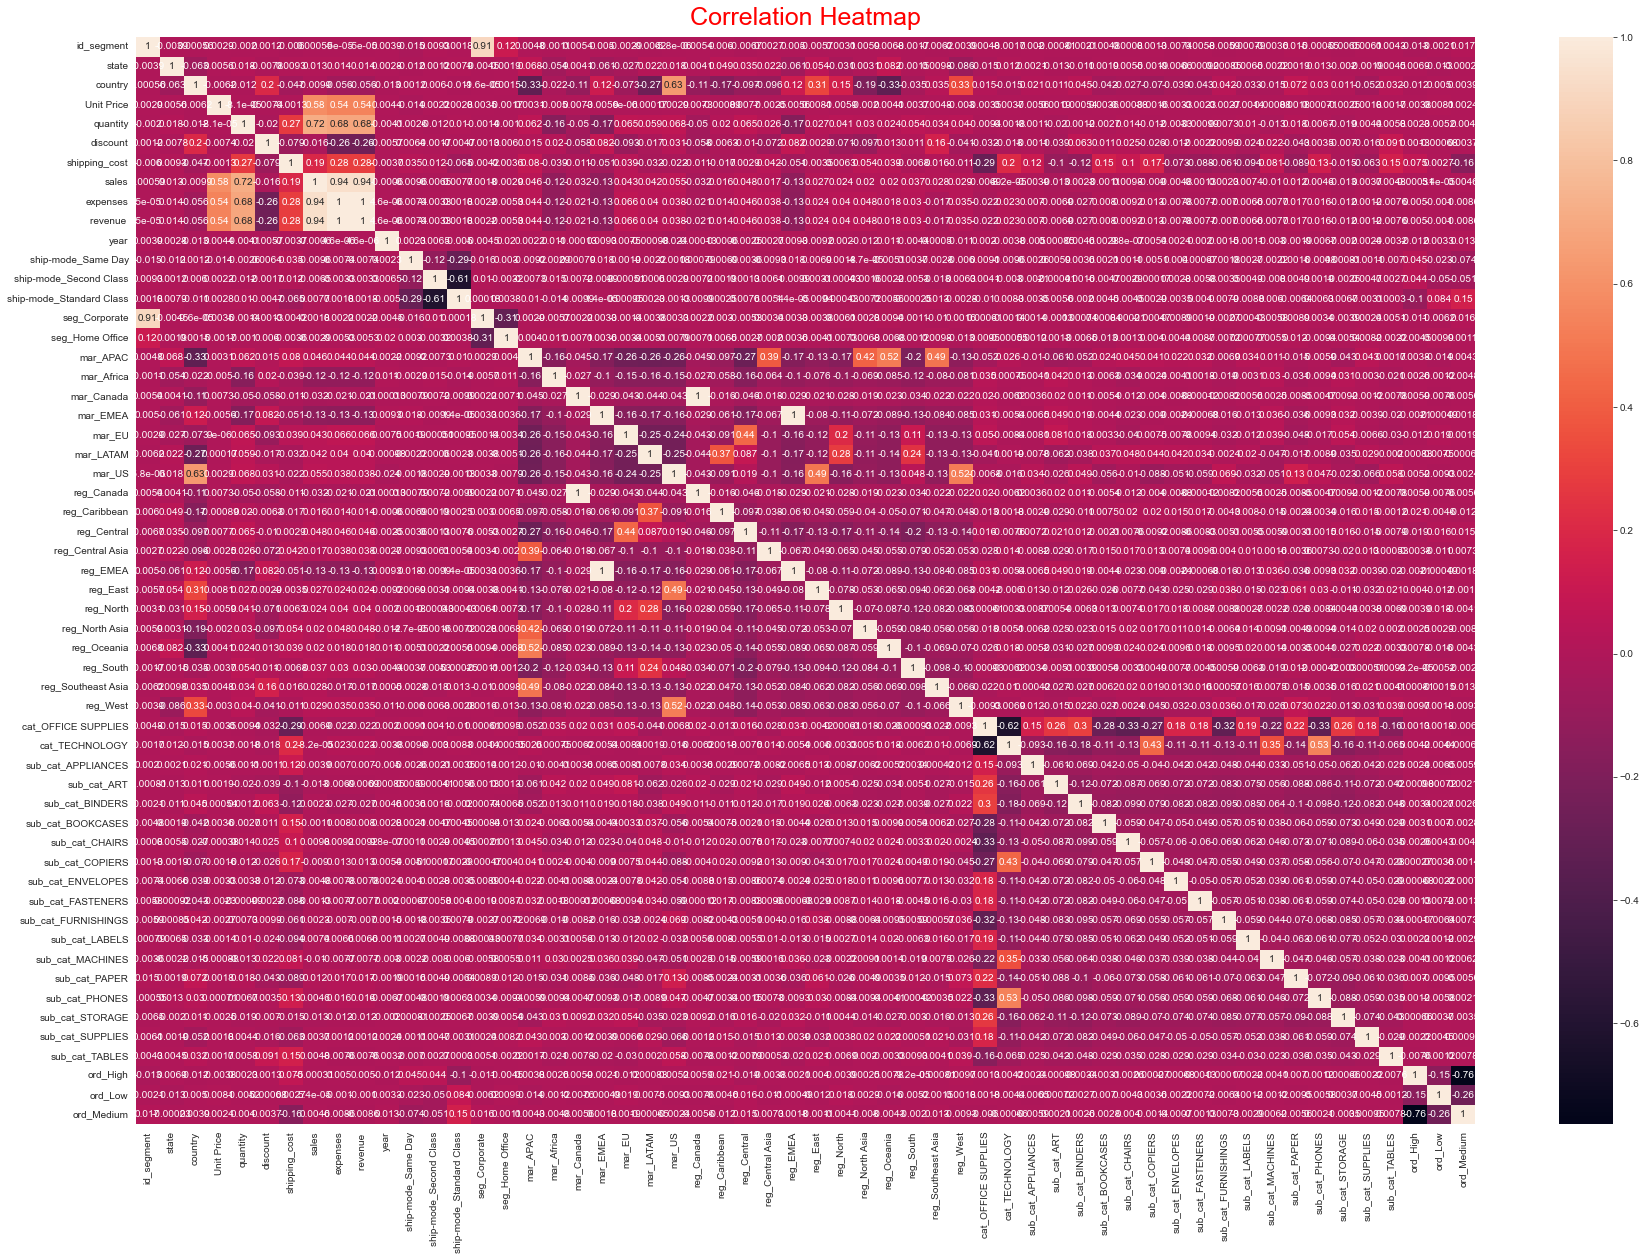

In [56]:
# Visualizing the collelations between all variables of the data.
plt.figure(1 , figsize = (30,20))
cor = sns.heatmap(data.corr(), annot = True)
cor.set_title('Correlation Heatmap', fontdict={'fontsize':25},color="red" ,pad=12)
plt.show()

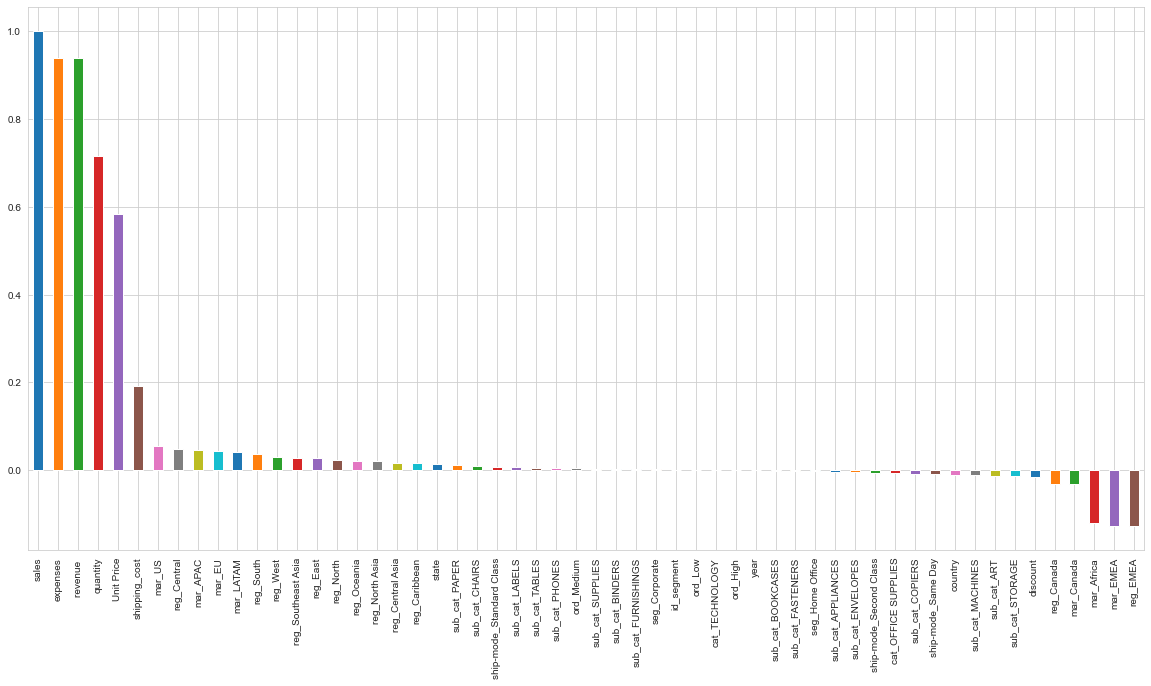

In [57]:
plt.figure(1 , figsize = (20,10))
data.corr()['sales'].sort_values(ascending = False).plot(kind='bar', color=['#1f77b4','#ff7f0e', '#2ca02c', '#d62728', '#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf'])
plt.show()

In [58]:
len(data.columns)

56

In [59]:
# Top 20 correlated features to the target
top20_corrs = abs(data.corr()['sales']).sort_values(ascending = False).head(20)
top20_corrs

sales                 1.000000
expenses              0.939793
revenue               0.939793
quantity              0.715229
Unit Price            0.584234
shipping_cost         0.191416
mar_EMEA              0.126286
reg_EMEA              0.126286
mar_Africa            0.119964
mar_US                0.054542
reg_Central           0.048155
mar_APAC              0.046430
mar_EU                0.042999
mar_LATAM             0.042028
reg_South             0.037442
reg_Canada            0.031666
mar_Canada            0.031666
reg_West              0.029265
reg_Southeast Asia    0.027870
reg_East              0.027278
Name: sales, dtype: float64

In [60]:
# # Quantify correlations between features
# corr = data[list(top20_corrs.index)].corr()
# plt.figure(figsize = (20, 10))
# sns.heatmap(corr, cmap='YlOrRd', annot = True, center = 0)
# plt.title('Correlogram', fontsize = 15, color = 'red')
# plt.show()

In [61]:
data1 =data.drop('sales',axis=1)

In [62]:
corr_matrix = data1.corr()

# Identify highly correlated features
high_corr_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            colname = corr_matrix.columns[i]
            high_corr_features.add(colname)

# Drop highly correlated features
data.drop(high_corr_features, axis=1, inplace=True)

# Print the remaining features
print(data.columns)

Index(['id_segment', 'state', 'country', 'Unit Price', 'quantity', 'discount',
       'shipping_cost', 'sales', 'expenses', 'year', 'ship-mode_Same Day',
       'ship-mode_Second Class', 'ship-mode_Standard Class', 'seg_Home Office',
       'mar_APAC', 'mar_Africa', 'mar_Canada', 'mar_EMEA', 'mar_EU',
       'mar_LATAM', 'mar_US', 'reg_Caribbean', 'reg_Central',
       'reg_Central Asia', 'reg_East', 'reg_North', 'reg_North Asia',
       'reg_Oceania', 'reg_South', 'reg_Southeast Asia', 'reg_West',
       'cat_OFFICE SUPPLIES', 'cat_TECHNOLOGY', 'sub_cat_APPLIANCES',
       'sub_cat_ART', 'sub_cat_BINDERS', 'sub_cat_BOOKCASES', 'sub_cat_CHAIRS',
       'sub_cat_COPIERS', 'sub_cat_ENVELOPES', 'sub_cat_FASTENERS',
       'sub_cat_FURNISHINGS', 'sub_cat_LABELS', 'sub_cat_MACHINES',
       'sub_cat_PAPER', 'sub_cat_PHONES', 'sub_cat_STORAGE',
       'sub_cat_SUPPLIES', 'sub_cat_TABLES', 'ord_High', 'ord_Low',
       'ord_Medium'],
      dtype='object')


In [63]:
len(data.columns)

52

In [64]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51275 entries, ES-2011-1630549 to IN-2011-71242
Data columns (total 52 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id_segment                51275 non-null  int64  
 1   state                     51275 non-null  int32  
 2   country                   51275 non-null  int32  
 3   Unit Price                51275 non-null  int64  
 4   quantity                  51275 non-null  int64  
 5   discount                  51275 non-null  float64
 6   shipping_cost             51275 non-null  float64
 7   sales                     51275 non-null  int64  
 8   expenses                  51275 non-null  float64
 9   year                      51275 non-null  int64  
 10  ship-mode_Same Day        51275 non-null  uint8  
 11  ship-mode_Second Class    51275 non-null  uint8  
 12  ship-mode_Standard Class  51275 non-null  uint8  
 13  seg_Home Office           51275 non-null  ui

### Scatter Matrix 

In [65]:
# sns.set()
# sns.pairplot(data)
# plt.figure(1 , figsize = (20,10))
# plt.show() 

### Features Distributions & Normalization

Now I'm gonna normalize our attributes using Feature Scaling and the box-cox transformation .

##### Unit Price

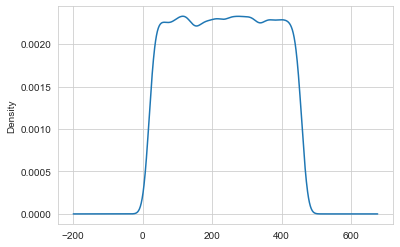

In [66]:
data['Unit Price'].plot(kind='kde')
plt.show()

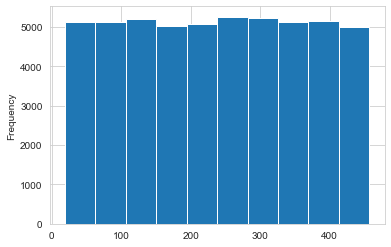

In [67]:
data['Unit Price'].plot(kind='hist')
plt.show()

In [68]:
scaler = MinMaxScaler()
normalized_column = scaler.fit_transform(data[['Unit Price']])
data['Unit Price'] = normalized_column

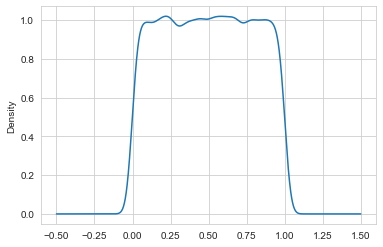

In [69]:
data['Unit Price'].plot(kind='kde')
plt.show()

##### Shipping Cost

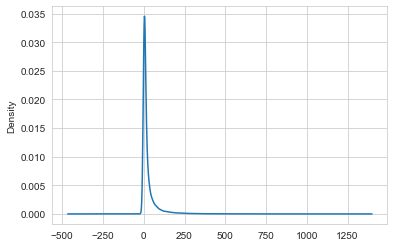

In [70]:
data['shipping_cost'].plot(kind='kde')
plt.show()

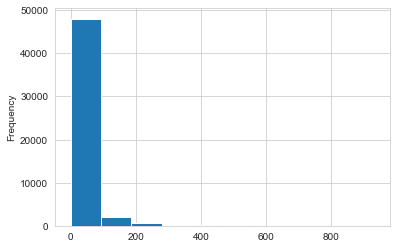

In [71]:
data['shipping_cost'].plot(kind='hist')
plt.show()

In [72]:
shifted_shipping_cost =data['shipping_cost'] + np.finfo(float).eps
transformed_shipping_cost, _ = stats.boxcox(shifted_shipping_cost)
data['shipping_cost'] = transformed_shipping_cost

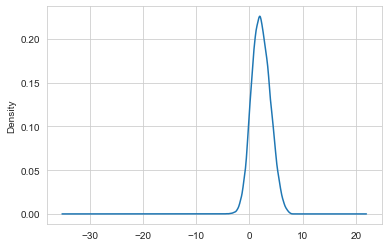

In [73]:
data['shipping_cost'].plot(kind='kde')
plt.show()

##### Expenses 

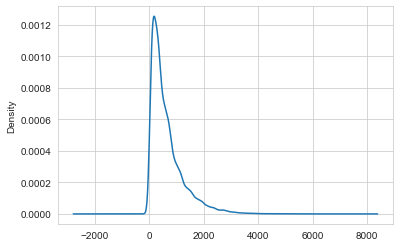

In [74]:
data['expenses'].plot(kind='kde')
plt.show()

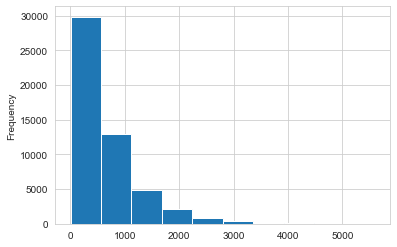

In [75]:
data['expenses'].plot(kind='hist')
plt.show()

In [76]:
data['expenses'], _ = pd.Series(stats.boxcox(data['expenses']))

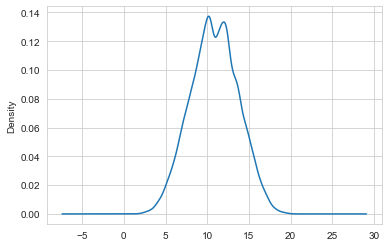

In [77]:
data['expenses'].plot(kind='kde')
plt.show()

### Handeling Unbalanced data

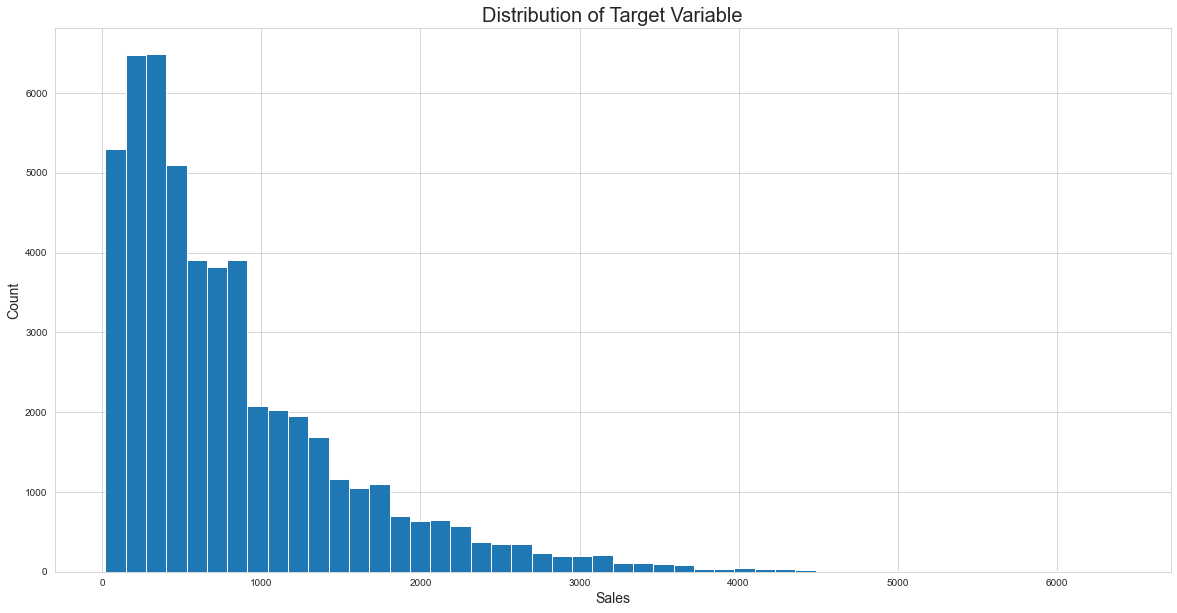

In [78]:
plt.figure(1 , figsize = (20,10))
plt.hist(data['sales'], bins=50)
plt.xlabel('Sales',size=14)
plt.ylabel('Count',size=14)
plt.title('Distribution of Target Variable',size=20)
plt.show()

In [79]:
mean = data['sales'].mean()
median = data['sales'].median()
std_dev = data['sales'].std()

print('Mean:', mean)
print('Median:', median)
print('Standard Deviation:', std_dev)

Mean: 826.3619112627987
Median: 605.0
Standard Deviation: 752.7489740694216


We can see that the data is skewed to the left that means it's unbalanced based on the statistics and the distribution of the target variable so we need to use a different evaluation metric such as the mean absolute error (MAE) or root mean squared error (RMSE) instead of the mean squared error (MSE) or R-squared .

Also we can try normalizing it with the box-cox transformation for example that could help .

In [80]:
data['sales'], _ = pd.Series(stats.boxcox(data['sales']))

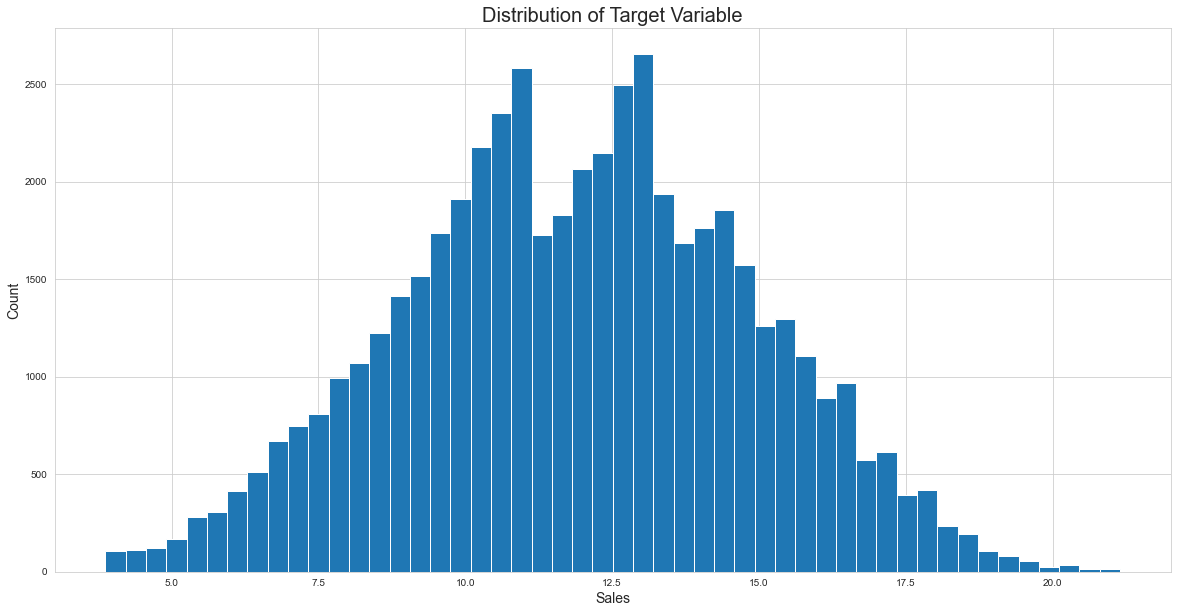

In [81]:
plt.figure(1 , figsize = (20,10))
plt.hist(data['sales'], bins=50)
plt.xlabel('Sales',size=14)
plt.ylabel('Count',size=14)
plt.title('Distribution of Target Variable',size=20)
plt.show()

In [82]:
mean = data['sales'].mean()
median = data['sales'].median()
std_dev = data['sales'].std()

print('Mean:', mean)
print('Median:', median)
print('Standard Deviation:', std_dev)

Mean: 11.901548984320996
Median: 11.962572470227117
Standard Deviation: 2.9719160755419174


In [115]:
data.head()

,id_segment,state,country,Unit Price,quantity,discount,shipping_cost,sales,expenses,year,ship-mode_Same Day,ship-mode_Second Class,ship-mode_Standard Class,seg_Home Office,mar_APAC,mar_Africa,mar_Canada,mar_EMEA,mar_EU,mar_LATAM,mar_US,reg_Caribbean,reg_Central,reg_Central Asia,reg_East,reg_North,reg_North Asia,reg_Oceania,reg_South,reg_Southeast Asia,reg_West,cat_OFFICE SUPPLIES,cat_TECHNOLOGY,sub_cat_APPLIANCES,sub_cat_ART,sub_cat_BINDERS,sub_cat_BOOKCASES,sub_cat_CHAIRS,sub_cat_COPIERS,sub_cat_ENVELOPES,sub_cat_FASTENERS,sub_cat_FURNISHINGS,sub_cat_LABELS,sub_cat_MACHINES,sub_cat_PAPER,sub_cat_PHONES,sub_cat_STORAGE,sub_cat_SUPPLIES,sub_cat_TABLES,ord_High,ord_Low,ord_Medium
order_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ES-2011-1630549,2,3,94,0.223744,14,0.7,2.458229,15.376721,10.774926,2011,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
MX-2013-132906,3,3,94,0.582192,1,0.7,-1.566614,9.648513,6.327482,2012,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
MX-2013-113579,2,3,94,0.958904,1,0.7,-1.316986,10.986060,7.355916,2012,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
CA-2013-116337,1,3,94,0.020548,2,0.7,-0.539763,5.887143,3.468168,2012,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
ES-2013-4232414,1,3,94,0.742009,2,0.7,-0.878350,12.369943,8.418531,2012,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


<a name = "Splitting"></a>
## 7.Splitting the Data

#### Standardization 

In [83]:
y=data[['sales']]
x=data.drop(['sales'],axis=1)

In [84]:
#Applying Standard scaling to get optimized result
sc = StandardScaler()

In [85]:
columns =x.columns

In [86]:
x = sc.fit_transform(x)

In [87]:
x = pd.DataFrame(x,columns=columns)

In [88]:
x.describe()

,id_segment,state,country,Unit Price,quantity,discount,shipping_cost,expenses,year,ship-mode_Same Day,ship-mode_Second Class,ship-mode_Standard Class,seg_Home Office,mar_APAC,mar_Africa,mar_Canada,mar_EMEA,mar_EU,mar_LATAM,mar_US,reg_Caribbean,reg_Central,reg_Central Asia,reg_East,reg_North,reg_North Asia,reg_Oceania,reg_South,reg_Southeast Asia,reg_West,cat_OFFICE SUPPLIES,cat_TECHNOLOGY,sub_cat_APPLIANCES,sub_cat_ART,sub_cat_BINDERS,sub_cat_BOOKCASES,sub_cat_CHAIRS,sub_cat_COPIERS,sub_cat_ENVELOPES,sub_cat_FASTENERS,sub_cat_FURNISHINGS,sub_cat_LABELS,sub_cat_MACHINES,sub_cat_PAPER,sub_cat_PHONES,sub_cat_STORAGE,sub_cat_SUPPLIES,sub_cat_TABLES,ord_High,ord_Low,ord_Medium
count,5.127500e+04,5.127500e+04,5.127500e+04,5.127500e+04,5.127500e+04,5.127500e+04,5.127500e+04,5.127500e+04,5.127500e+04,5.127500e+04,5.127500e+04,5.127500e+04,5.127500e+04,5.127500e+04,5.127500e+04,5.127500e+04,5.127500e+04,5.127500e+04,5.127500e+04,5.127500e+04,5.127500e+04,5.127500e+04,5.127500e+04,5.127500e+04,5.127500e+04,5.127500e+04,5.127500e+04,5.127500e+04,5.127500e+04,5.127500e+04,5.127500e+04,5.127500e+04,5.127500e+04,5.127500e+04,5.127500e+04,5.127500e+04,5.127500e+04,5.127500e+04,5.127500e+04,5.127500e+04,5.127500e+04,5.127500e+04,5.127500e+04,5.127500e+04,5.127500e+04,5.127500e+04,5.127500e+04,5.127500e+04,5.127500e+04,5.127500e+04,5.127500e+04
mean,-2.034084e-15,2.186733e-14,-1.143869e-14,2.139142e-16,2.612310e-15,-8.508693e-16,-2.897482e-16,2.216776e-16,8.981882e-14,-1.430509e-15,-9.995320e-16,1.849962e-15,2.673718e-15,3.155700e-14,9.221821e-15,1.954616e-15,-1.377376e-14,3.180510e-16,-5.920346e-15,1.604576e-15,-3.100516e-14,-5.082624e-16,-5.722201e-16,-3.888387e-14,-1.016482e-14,-1.159924e-14,-3.330046e-14,-4.095913e-15,-6.864894e-15,-5.974418e-14,9.883663e-15,-5.856588e-15,-8.198448e-16,-7.841606e-16,-2.782905e-15,1.293856e-15,2.693255e-15,-7.458891e-16,2.959868e-15,1.187259e-15,-1.350514e-15,4.257302e-16,1.720880e-15,2.006320e-15,7.659707e-15,-1.817799e-16,-4.719070e-16,1.415542e-15,-3.936926e-15,4.471864e-15,-1.586120e-15
std,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00
min,-8.924283e-01,-1.845893e+00,-1.693707e+00,-1.732146e+00,-1.086769e+00,-6.732217e-01,-1.340315e+01,-3.216828e+00,-1.024865e+01,-2.357629e-01,-5.016145e-01,-1.224795e+00,-4.719073e-01,-5.225505e-01,-3.134078e-01,-8.686506e-02,-3.297280e-01,-4.920334e-01,-5.011272e-01,-4.919722e-01,-1.846720e-01,-5.259665e-01,-2.038648e-01,-2.424630e-01,-3.207459e-01,-2.185766e-01,-2.700845e-01,-3.858638e-01,-2.548876e-01,-2.580834e-01,-1.249988e+00,-4.964016e-01,-1.882557e-01,-3.243939e-01,-3.691381e-01,-2.220801e-01,-2.679168e-01,-2.128331e-01,-2.233342e-01,-2.225148e-01,-2.566620e-01,-2.313987e-01,-1.727598e-01,-2.722396e-01,-2.645988e-01,-3.307450e-01,-2.227561e-01,-1.306079e-01,-6.582275e-01,-2.227079e-01,-1.160327e+00
25%,-8.924283e-01,-8.232760e-01,-7.512360e-01,-8.688930e-01,-6.479206e-01,-6.732217e-01,-7.086727e-01,-6.906824e-01,-6.768205e-01,-2.357629e-01,-5.016145e-01,-1.224795e+00,-4.719073e-01,-5.225505e-01,-3.134078e-01,-8.686506e-02,-3.297280e-01,-4.920334e-01,-5.011272e-01,-4.919722e-01,-1.846720e-01,-5.259665e-01,-2.038648e-01,-2.424630e-01,-3.207459e-01,-2.185766e-01,-2.700845e-01,-3.858638e-01,-2.548876e-01,-2.580834e-01,-1.249988e+00,-4.964016e-01,-1.882557e-01,-3.243939e-01,-3.691381e-01,-2.220801e-01,-2.679168e-01,-2.128331e-01,-2.233342e-01,-2.225148e-01,-2.56

In [89]:
x.head()

,id_segment,state,country,Unit Price,quantity,discount,shipping_cost,expenses,year,ship-mode_Same Day,ship-mode_Second Class,ship-mode_Standard Class,seg_Home Office,mar_APAC,mar_Africa,mar_Canada,mar_EMEA,mar_EU,mar_LATAM,mar_US,reg_Caribbean,reg_Central,reg_Central Asia,reg_East,reg_North,reg_North Asia,reg_Oceania,reg_South,reg_Southeast Asia,reg_West,cat_OFFICE SUPPLIES,cat_TECHNOLOGY,sub_cat_APPLIANCES,sub_cat_ART,sub_cat_BINDERS,sub_cat_BOOKCASES,sub_cat_CHAIRS,sub_cat_COPIERS,sub_cat_ENVELOPES,sub_cat_FASTENERS,sub_cat_FURNISHINGS,sub_cat_LABELS,sub_cat_MACHINES,sub_cat_PAPER,sub_cat_PHONES,sub_cat_STORAGE,sub_cat_SUPPLIES,sub_cat_TABLES,ord_High,ord_Low,ord_Medium
0,0.246400,-1.836029,0.319754,-0.956010,4.618258,2.624368,0.152981,-0.028289,-1.546987,-0.235763,-0.501615,0.816463,2.119060,-0.522551,3.190732,-0.086865,-0.329728,-0.492033,-0.501127,-0.491972,-0.184672,-0.525967,-0.203865,-0.242463,-0.320746,-0.218577,-0.270085,-0.385864,-0.254888,-0.258083,0.800008,-0.496402,-0.188256,3.082672,-0.369138,-0.22208,-0.267917,-0.212833,-0.223334,-0.222515,-0.256662,-0.231399,-0.17276,-0.27224,-0.264599,-0.330745,-0.222756,-0.130608,-0.658228,-0.222708,0.861826
1,1.385228,-1.836029,0.319754,0.287391,-1.086769,2.624368,-2.185191,-1.593530,-0.676820,-0.235763,-0.501615,0.816463,-0.471907,-0.522551,3.190732,-0.086865,-0.329728,-0.492033,-0.501127,-0.491972,-0.184672,-0.525967,-0.203865,-0.242463,-0.320746,-0.218577,-0.270085,-0.385864,-0.254888,-0.258083,0.800008,-0.496402,-0.188256,-0.324394,-0.369138,-0.22208,-0.267917,-0.212833,-0.223334,-0.222515,-0.256662,-0.231399,-0.17276,-0.27224,-0.264599,-0.330745,4.489215,-0.130608,-0.658228,-0.222708,0.861826
2,0.246400,-1.836029,0.319754,1.594151,-1.086769,2.624368,-2.040173,-1.231581,-0.676820,-0.235763,-0.501615,0.816463,2.119060,-0.522551,3.190732,-0.086865,-0.329728,-0.492033,-0.501127,-0.491972,-0.184672,-0.525967,-0.203865,-0.242463,-0.320746,-0.218577,-0.270085,-0.385864,-0.254888,-0.258083,0.800008,-0.496402,-0.188256,-0.324394,-0.369138,-0.22208,-0.267917,-0.212833,-0.223334,-0.222515,-0.256662,-0.231399,-0.17276,-0.27224,-0.264599,3.023477,-0.222756,-0.130608,-0.658228,-0.222708,0.861826
3,-0.892428,-1.836029,0.319754,-1.660868,-0.647921,2.624368,-1.588657,-2.599843,-0.676820,-0.235763,-0.501615,0.816463,-0.471907,-0.522551,3.190732,-0.086865,-0.329728,-0.492033,-0.501127,-0.491972,-0.184672,-0.525967,-0.203865,-0.242463,-0.320746,-0.218577,-0.270085,-0.385864,-0.254888,-0.258083,0.800008,-0.496402,-0.188256,-0.324394,-0.369138,-0.22208,-0.267917,-0.212833,-0.223334,-0.222515,-0.256662,-0.231399,-0.17276,-0.27224,-0.264599,3.023477,-0.222756,-0.130608,-0.658228,-0.222708,0.861826
4,-0.892428,-1.836029,0.319754,0.841774,-0.647921,2.624368,-1.785354,-0.857603,-0.676820,-0.235763,-0.501615,0.816463,-0.471907,-0.522551,3.190732,-0.086865,-0.329728,-0.492033,-0.501127,-0.491972,-0.184672,-0.525967,-0.203865,-0.242463,-0.320746,-0.218577,-0.270085,-0.385864,-0.254888,-0.258083,0.800008,-0.496402,-0.188256,3.082672,-0.369138,-0.22208,-0.267917,-0.212833,-0.223334,-0.222515,-0.256662,-0.231399,-0.17276,-0.27224,-0.264599,-0.330745,-0.222756,-0.130608,-0.658228,-0.222708,0.861826


In [90]:
y.head()

,sales
order_id,
ES-2011-1630549,15.376721
MX-2013-132906,9.648513
MX-2013-113579,10.986060
CA-2013-116337,5.887143
ES-2013-4232414,12.369943


In [91]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.1,random_state = 7)

<a name = "Model"></a>
## 8.Model training

#### XGBoost Regressor Model

In [92]:
xgb = XGBRegressor()
xgb.fit(x_train, y_train)
y_pred = xgb.predict(x_test)

In [93]:
print('Accuracy: {}'.format(xgb.score(x_test,y_test)*100),"%")

Accuracy: 99.92976039866134 %


In [94]:
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print('Mean Absolute Error:', mae)
print('Root Mean Squared Error:', rmse)

Mean Absolute Error: 0.04516180172088965
Root Mean Squared Error: 0.07860470787466131


<a name = "Predictions"></a>
## 9.Test set predictions

### Feature Importances

In [95]:
print(xgb.feature_importances_)

[2.60165198e-05 8.71201482e-05 1.17343297e-04 5.18792421e-02
 3.22882757e-02 1.07632853e-01 1.07325027e-02 7.88632870e-01
 6.11525466e-05 8.74675534e-05 1.17980708e-04 6.76734562e-05
 7.14338385e-05 1.18580705e-04 6.68424182e-05 8.09068638e-07
 1.26674597e-04 1.32923975e-04 1.80125746e-04 2.35526008e-04
 8.40280154e-06 4.02954826e-03 1.32548288e-04 8.05315503e-05
 1.26505445e-04 8.31415164e-05 1.27371604e-04 2.88979587e-04
 1.85639787e-04 8.57449704e-05 2.25374009e-04 2.65973154e-04
 1.40408607e-04 2.74511658e-05 7.70373299e-05 1.35337294e-04
 7.61213814e-05 1.13667826e-04 7.89504775e-05 1.52838358e-04
 1.01371603e-04 1.44303558e-05 9.56788572e-05 1.02298778e-04
 1.00913741e-04 8.12238140e-05 2.75197690e-05 1.17918986e-04
 1.00203193e-04 1.03441096e-04 5.00222195e-05]


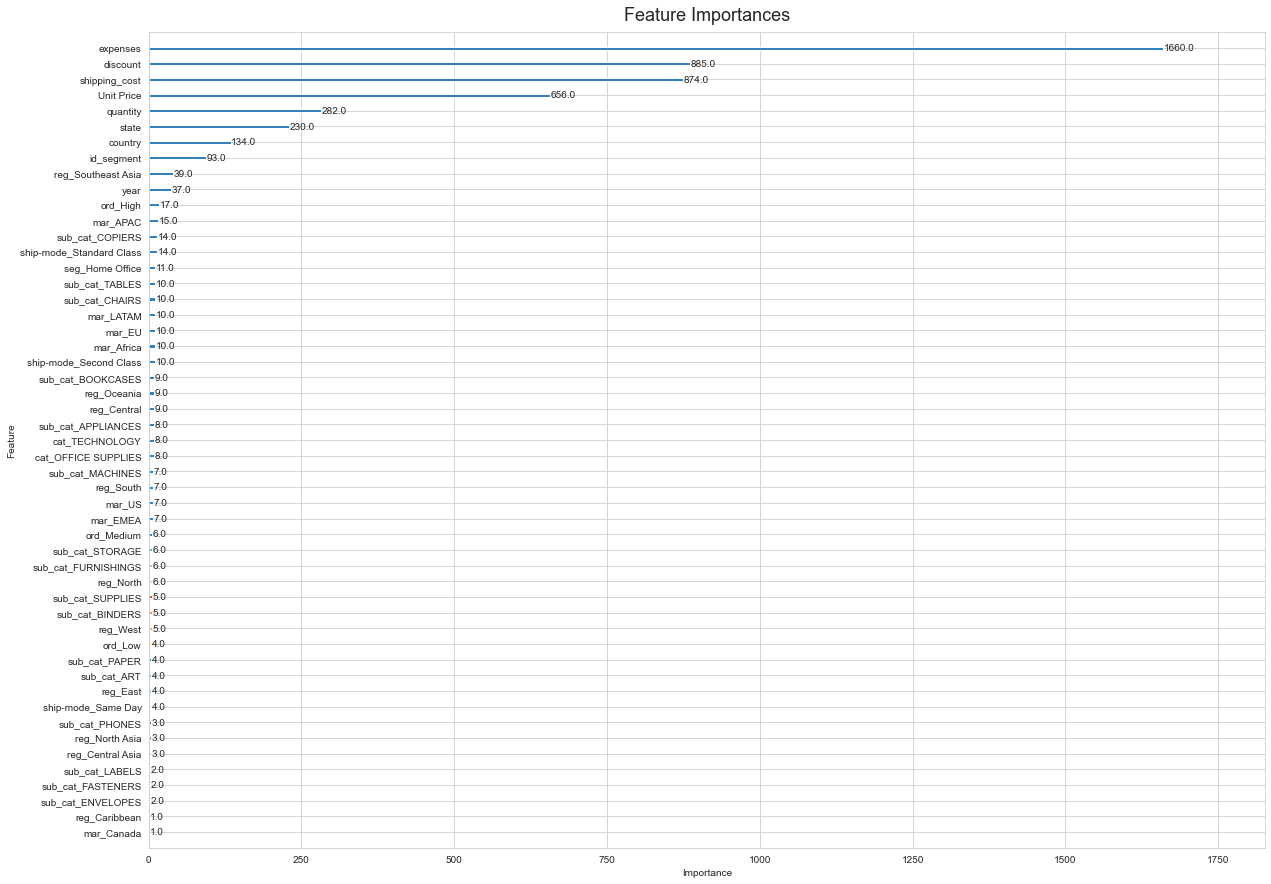

In [96]:
cmap = plt.cm.get_cmap('tab20c_r')
colors = [cmap(i) for i in range(x.shape[1])]
fig, ax = plt.subplots(figsize=(20, 15))
plot_importance(xgb, ax=ax, color=colors)
plt.title('Feature Importances', fontdict={'fontsize':18}, pad=12)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

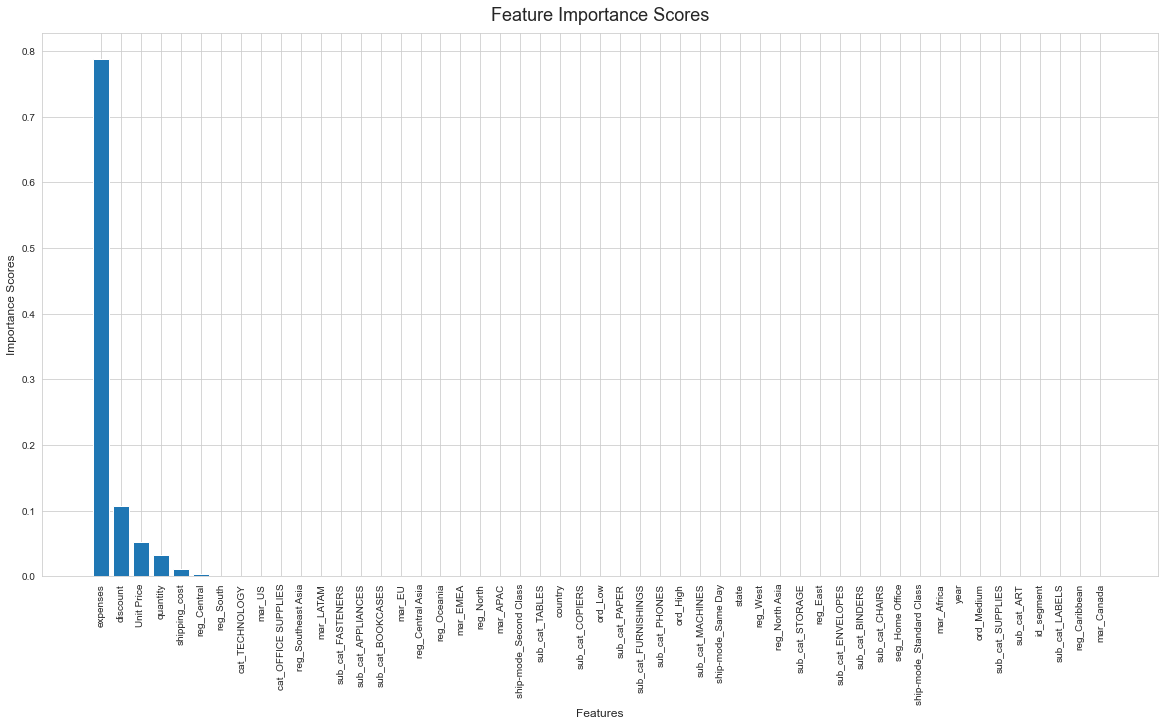

In [97]:
importance_scores = xgb.feature_importances_
feature_names = x_train.columns

# Create a dictionary of feature names and their importance scores
feature_importances = dict(zip(feature_names, importance_scores))

# Sort the dictionary by importance scores in descending order
sorted_feature_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

# Extract the feature names and their importance scores
features, scores = zip(*sorted_feature_importances)

# Plot the feature importance scores as a bar chart
plt.figure(figsize=(20,10))
plt.bar(features, scores)
plt.xticks(rotation=90)
plt.xlabel("Features", fontdict={'fontsize':12})
plt.ylabel("Importance Scores", fontdict={'fontsize':12})
plt.title("Feature Importance Scores", fontdict={'fontsize':18}, pad=12)
plt.show()


In [98]:
# Get feature importance scores and sort in descending order
importance_scores = xgb.feature_importances_
feature_names = x_train.columns
feature_importances = list(zip(feature_names, importance_scores))
feature_importances_sorted = sorted(feature_importances, key=lambda x: x[1], reverse=True)

# Print feature importance scores
print("Feature Importances:")
for feature, importance in feature_importances_sorted:
    print(feature, ": ", importance)

# Set a threshold for selecting important features
threshold = 0.01

# Identify non-important features
non_important_features = [feature for feature, importance in feature_importances_sorted if importance < threshold]
print("Non-important Features:", non_important_features)

# Drop non-important features from the training and testing sets
x_train_dropped = x_train.drop(non_important_features, axis=1)
x_test_dropped = x_test.drop(non_important_features, axis=1)

Feature Importances:
expenses :  0.78863287
discount :  0.10763285
Unit Price :  0.051879242
quantity :  0.032288276
shipping_cost :  0.010732503
reg_Central :  0.0040295483
reg_South :  0.0002889796
cat_TECHNOLOGY :  0.00026597315
mar_US :  0.00023552601
cat_OFFICE SUPPLIES :  0.00022537401
reg_Southeast Asia :  0.00018563979
mar_LATAM :  0.00018012575
sub_cat_FASTENERS :  0.00015283836
sub_cat_APPLIANCES :  0.0001404086
sub_cat_BOOKCASES :  0.0001353373
mar_EU :  0.00013292397
reg_Central Asia :  0.00013254829
reg_Oceania :  0.0001273716
mar_EMEA :  0.0001266746
reg_North :  0.00012650545
mar_APAC :  0.000118580705
ship-mode_Second Class :  0.00011798071
sub_cat_TABLES :  0.000117918986
country :  0.0001173433
sub_cat_COPIERS :  0.000113667826
ord_Low :  0.000103441096
sub_cat_PAPER :  0.00010229878
sub_cat_FURNISHINGS :  0.0001013716
sub_cat_PHONES :  0.00010091374
ord_High :  0.00010020319
sub_cat_MACHINES :  9.567886e-05
ship-mode_Same Day :  8.746755e-05
state :  8.712015e-05
reg

In [99]:
x_train_dropped.head()

,Unit Price,quantity,discount,shipping_cost,expenses
32903,-0.639220,-0.647921,0.268947,-1.163996,-0.682205
45087,0.414107,0.668624,-0.673222,0.515959,1.162003
39631,0.469545,-0.647921,-0.673222,-0.844344,0.147584
13434,0.620021,1.107472,-0.673222,-0.641205,1.481119
46197,-1.716307,-0.209072,0.268947,1.023548,-1.516042


In [114]:
y_train

,sales
order_id,
ES-2011-1630549,15.376721
MX-2013-132906,9.648513
CA-2013-116337,5.887143
ES-2013-4232414,12.369943
IT-2013-2373016,9.547720
...,...
ES-2013-5670479,14.045123
SU-2014-3390,14.160950
EZ-2014-8670,15.918972


In [100]:
# Train a new XGBRegressor model with the dropped features
xgb_dropped = XGBRegressor()
xgb_dropped.fit(x_train_dropped, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [101]:
# Evaluate the new model on the testing set
y_pred_dropped = xgb_dropped.predict(x_test_dropped)
mae_dropped = mean_absolute_error(y_test, y_pred_dropped)
rmse_dropped = mean_squared_error(y_test, y_pred_dropped, squared=False)

print('Mean Absolute Error (dropped features):', mae_dropped)
print('Root Mean Squared Error (dropped features):', rmse_dropped)

Mean Absolute Error (dropped features): 0.044580659349926395
Root Mean Squared Error (dropped features): 0.07735417768549063


In [102]:
print('Accuracy: {}'.format(xgb_dropped.score(x_test_dropped,y_test)*100),"%")

Accuracy: 99.93197751879403 %


## Grid Search CV

In [103]:
param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 1000]
}

In [104]:
clf = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5,verbose=2)

clf.fit(x_train_dropped, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.2s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.2s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.2s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.2s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.2s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.5s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.5s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.5s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.5s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.5s
[CV] END .learning_rate=0.01, max_depth=3, n_estimators=1000; total time=   6.2s
[CV] END .learning_rate=0.01, max_depth=3, n_es

[CV] END ..learning_rate=0.3, max_depth=3, n_estimators=1000; total time=   6.0s
[CV] END ..learning_rate=0.3, max_depth=3, n_estimators=1000; total time=   6.0s
[CV] END ..learning_rate=0.3, max_depth=3, n_estimators=1000; total time=   6.0s
[CV] END ..learning_rate=0.3, max_depth=3, n_estimators=1000; total time=   6.0s
[CV] END ....learning_rate=0.3, max_depth=5, n_estimators=50; total time=   0.4s
[CV] END ....learning_rate=0.3, max_depth=5, n_estimators=50; total time=   0.4s
[CV] END ....learning_rate=0.3, max_depth=5, n_estimators=50; total time=   0.4s
[CV] END ....learning_rate=0.3, max_depth=5, n_estimators=50; total time=   0.4s
[CV] END ....learning_rate=0.3, max_depth=5, n_estimators=50; total time=   0.4s
[CV] END ...learning_rate=0.3, max_depth=5, n_estimators=100; total time=   0.9s
[CV] END ...learning_rate=0.3, max_depth=5, n_estimators=100; total time=   0.9s
[CV] END ...learning_rate=0.3, max_depth=5, n_estimators=100; total time=   0.9s
[CV] END ...learning_rate=0.

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    callbacks=None, colsample_bylevel=1,
                                    colsample_bynode=1, colsample_bytree=1,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=0, gpu_id=-1,
                                    grow_policy='depthwise',
                                    importance_type=None,
                                    interaction_constraints='',
                                    learning_rate=0.300000012, max_bin=256,
                                    max_cat_threshold=64, max_cat_to_onehot=4,
                                    max_delta_step=0, max_depth=6, max_leaves=0,
                                    min_child_weight=1, missing=nan,
                                    monotone_constrain

In [105]:
print('Best parameters:', clf.best_params_)

Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 1000}


In [106]:
y_pred = clf.predict(x_test_dropped)

In [107]:
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print('Mean Absolute Error:', mae)
print('Root Mean Squared Error:', rmse)

Mean Absolute Error: 0.02282889309948217
Root Mean Squared Error: 0.040620081627439075


In [108]:
print('Accuracy: {}'.format(clf.score(x_test_dropped,y_test)*100),"%")

Accuracy: 99.98124286494206 %


## Cross Validation

In [109]:
from ipywidgets import IntProgress
from IPython.display import display
import time

xgb = XGBRegressor(**clf.best_params_)

from contextlib import contextmanager
import warnings

@contextmanager
def suppress_warnings():
    warnings.filterwarnings('ignore')
    yield
    warnings.resetwarnings()

with suppress_warnings():
    mae_scores = []
    rmse_scores = []
    progress = IntProgress(min=0, max=5)
    display(progress)
    for i, (train_index, test_index) in enumerate(KFold(n_splits=5, shuffle=True, random_state=42).split(x)):
        x_train, x_test = x.iloc[train_index], x.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        xgb.fit(x_train, y_train)
        
        y_pred = xgb.predict(x_test)
        
        mae_scores.append(mean_absolute_error(y_test, y_pred))
        rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
        
        progress.value = i+1
        time.sleep(1)
    
    print("MAE scores: ", mae_scores)
    print("RMSE scores: ", rmse_scores)


IntProgress(value=0, max=5)

MAE scores:  [0.023847378174299206, 0.02448241606975706, 0.025295220290323096, 0.024431527526461428, 0.02396381214741188]
RMSE scores:  [0.04177690790595075, 0.04222835116627958, 0.06075811549426601, 0.043525068034410606, 0.044518162247560986]


In [110]:
print('Mean MAE:', np.mean(mae_scores))
print('Standard deviation of MAE:',np.std(mae_scores))

Mean MAE: 0.024404070841650534
Standard deviation of MAE: 0.0005108372789671367


In [111]:
print("Mean RMSE:", np.mean(rmse_scores))
print('Standard deviation of RMSE:', np.std(rmse_scores))

Mean RMSE: 0.046561320969693586
Standard deviation of RMSE: 0.007163903124771879


In [112]:
print('Accuracy: {}'.format(xgb.score(x_test,y_test)*100),"%")

Accuracy: 99.97798721422627 %


In [113]:
import pickle

pickle.dump(sc,open('scaler.pickle','wb'))
ssc = pickle.load(open('scaler.pickle','rb'))

pickle.dump(xgb,open('xgbmodel.pkl','wb'))
model =pickle.load(open('xgbmodel.pkl','rb'))


C:\Users\benma\AppData\Local\Temp\ipykernel_17768\1306166583.py:3: ResourceWarning: unclosed file <_io.BufferedWriter name='scaler.pickle'>
  pickle.dump(sc,open('scaler.pickle','wb'))
C:\Users\benma\AppData\Local\Temp\ipykernel_17768\1306166583.py:4: ResourceWarning: unclosed file <_io.BufferedReader name='scaler.pickle'>
  ssc = pickle.load(open('scaler.pickle','rb'))
C:\Users\benma\AppData\Local\Temp\ipykernel_17768\1306166583.py:6: ResourceWarning: unclosed file <_io.BufferedWriter name='xgbmodel.pkl'>
  pickle.dump(xgb,open('xgbmodel.pkl','wb'))
C:\Users\benma\AppData\Local\Temp\ipykernel_17768\1306166583.py:7: ResourceWarning: unclosed file <_io.BufferedReader name='xgbmodel.pkl'>
  model =pickle.load(open('xgbmodel.pkl','rb'))
